##### Copyright 2019 The TensorFlow Authors.

(modified by Chelsea Parlett)

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Setup

In [1]:
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, BatchNormalization, LeakyReLU, ReLU, Reshape, Conv2DTranspose, LSTM, Embedding, Dropout, add
from tensorflow.keras import layers
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
import numpy as np

import glob
import PIL
import time

from IPython import display

### Load and prepare the dataset

We're going to use the pokemon image dataset (from [here](https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset), also on Canvas). Upload the zipfile to Colab and rename as "poke.zip" if not already named that.

We'll use `unzip` to unzip these files

In [3]:
!ls

image.zip  sample_data


In [5]:
!unzip -q image.zip

replace image/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


#### GrayScale

To make our model simpler, we're going to convert these images into grayscale images (taking them from `128,128,3` to `128,128,1`). 

In [2]:
import cv2
import glob, os, errno

########################################################
BUFFER_SIZE = 60000
BATCH_SIZE = 256
BASE_DIR = "."
OUTPUT_DIR = "./kaggle/working"
trained_models_folder = OUTPUT_DIR + "/trained_model/"
generated_images_folder = OUTPUT_DIR + "/" 
########################################################

# Replace mydir with the directory you want
#mydir = r'./gray/'

#check if directory exist, if not create it
#try:
    ##os.makedirs(mydir)
#except OSError as e:
  #for fil in glob.glob(BASE_DIR + "/image/Apple/" + "*.png"):
      # print(fil[26:])
      #image = cv2.imread(fil) 
      #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to greyscale
      #cv2.imwrite(os.path.join(mydir,fil[26:]),gray_image)

#### Load Data
Now that our images are grayscale, let's load them in using `image_dataset_from_directory()`. Note, that for this GAN there's no training/testing set, just one set of training data.

In [3]:
# from https://www.kaggle.com/code/zhangkw/pokemon-gan

if not os.path.exists(trained_models_folder):
    os.makedirs(trained_models_folder)

def get_dataset(folder, image_size, batch_size):
    # resize images to fixed size and get a batch dataset
    dataset = preprocessing.image_dataset_from_directory(
        folder, label_mode=None,
        image_size=(image_size, image_size),
        batch_size=batch_size,
        color_mode='rgb'
    )
    # map images to the [-1, 1] range
    dataset = dataset.map(lambda x: (x - 127.5) / 127.5)
    return dataset

image_size = 72
batch_size = 32
dataset = get_dataset(BASE_DIR + "/image/", image_size, batch_size)

Found 14253 files belonging to 1 classes.


In [5]:
print(dataset.element_spec)

TensorSpec(shape=(None, 72, 72, 3), dtype=tf.float32, name=None)


## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 128x128x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

`assert` statements help us to keep track of the size of our input as it passes through the generator.

In [21]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(18*18*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((18, 18, 256)))
    assert model.output_shape == (None, 18, 18, 256)  
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 18, 18, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 36, 36, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    print(model.output_shape)
    assert model.output_shape == (None, 72, 72, 3)

    return model



Use the (as yet untrained) generator to create an image.

(None, 72, 72, 3)


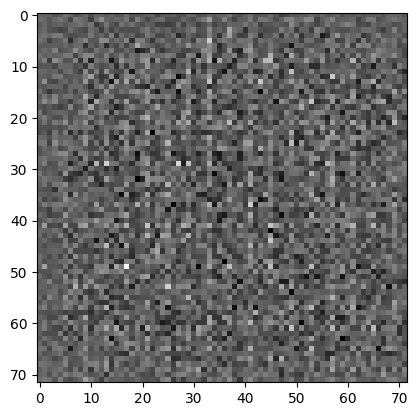

In [22]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [23]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[72, 72, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [24]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00017625]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [25]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [26]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [27]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [29]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [30]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [31]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [32]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [33]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

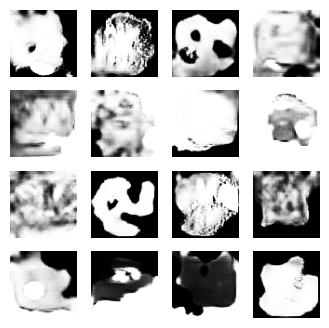

In [34]:
train(dataset, EPOCHS)

Restore the latest checkpoint.

In [36]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [35]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs
import imageio


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-kykkkad1
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-kykkkad1
  Resolved https://github.com/tensorflow/docs to commit ba879887790ded183c04540d5386df4962f48eeb
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=183463 sha256=8b240cad11520d229f9d29a44e87dfa286c1149b9c343e7970372f1bf1424625
  Stored in directory: /tmp/pip-ephem-wheel-cache-sdp05wus/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
# Display a single image using the epoch number
# def display_image(epoch_no):
#   return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
# display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [37]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-37-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-37-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



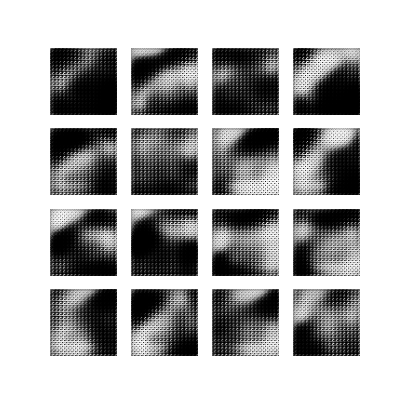

In [38]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)